In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pathlib
from sklearn.metrics import  classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import keras
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,GlobalAveragePooling2D,BatchNormalization,Dropout
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score
from skimage.transform import resize
import seaborn as sns


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)


### EDA

In [3]:
df = pd.read_csv('HAM10000_metadata.txt')

In [4]:
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern


In [5]:
df['dx'].value_counts(normalize=True)

nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: dx, dtype: float64

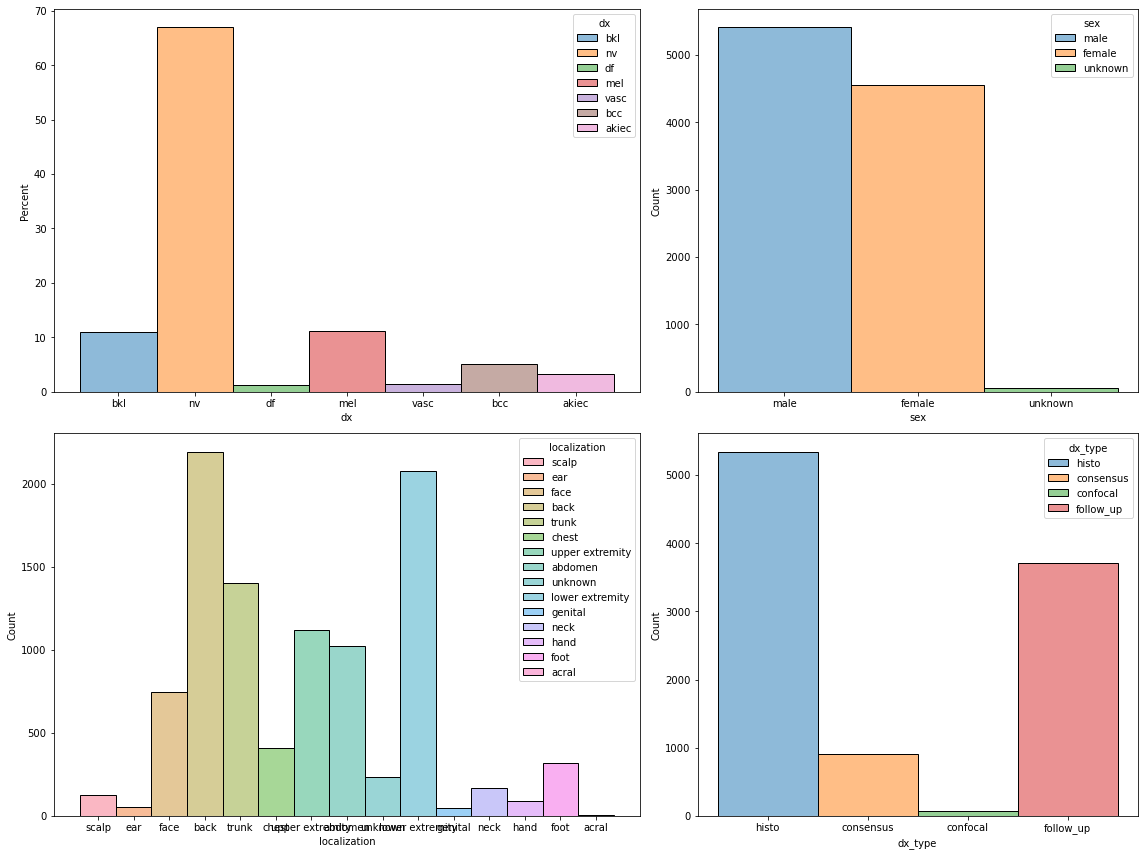

In [61]:
f, axs = plt.subplots(2, 2, figsize=(16, 12), gridspec_kw=dict(width_ratios=[4, 3]))
sns.histplot(data=df, x="dx", hue="dx", ax=axs[0,0], stat='percent')
sns.histplot(data=df, x="sex", hue="sex", ax=axs[0,1])
sns.histplot(data=df, x="localization", hue="localization", ax=axs[1,0], )
sns.histplot(data=df, x="dx_type", hue="dx_type", ax=axs[1,1])
f.tight_layout()

(array([0.00147679, 0.00139409, 0.00491476, 0.00548185, 0.0205333 ,
        0.02937041, 0.01192065, 0.01812318, 0.01623288, 0.00819914]),
 array([ 0. ,  8.5, 17. , 25.5, 34. , 42.5, 51. , 59.5, 68. , 76.5, 85. ]),
 <BarContainer object of 10 artists>)

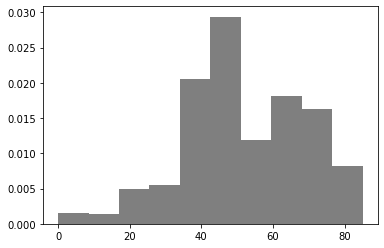

In [6]:
plt.hist(df.age,density = True, color = 'tab:gray')


## Prepossessing

In [2]:
meta_root ='HAM10000_metadata.txt'
test_meta = 'ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv'
df = pd.read_csv(meta_root)
test_df = pd.read_csv(test_meta)

In [7]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [3]:
# rename columns as lowercase
test_col = [x.lower() for x in  test_df.columns]
test_df.columns = test_col
# reverse one-hot encoding
test_df['dx'] = test_df.iloc[:,1:].idxmax(1)
# drop others
test_df.drop(['mel', 'nv', 'bcc', 'akiec', 'bkl', 'df', 'vasc'], axis=1, inplace= True)
test_df.columns = ['image_id','dx']
test_df

,image_id,dx
0,ISIC_0034321,nv
1,ISIC_0034322,nv
2,ISIC_0034323,bcc
3,ISIC_0034324,nv
4,ISIC_0034325,nv
...,...,...
188,ISIC_0034519,nv
189,ISIC_0034520,nv
190,ISIC_0034521,bkl
191,ISIC_0034522,nv


In [5]:
Train_root= 'HAM10000_images/'

Train_list = tf.data.Dataset.list_files(Train_root + "*.jpg")

Test_root= 'ISIC2018_Task3_Validation_Input/ISIC2018_Task3_Validation_Input/'

Test_list = tf.data.Dataset.list_files(Test_root + "*.jpg")

In [6]:

#X = df_data.drop('dx', axis=1)
y = df['dx']

df_train, df_val = train_test_split(df, test_size=0.1, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(9013, 8)
(1002, 8)


## Data Augmentation

In [ ]:
df_data=df.copy()
df_data.set_index('image_id',inplace=True)
# Create a new directory


base_dir = 'base/'
os.mkdir(base_dir)

#### Create folders

In [ ]:

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

#Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

#create file
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
for img_class in targetnames:
    x = os.path.join(train_dir, img_class)
    os.mkdir(x)
    y = os.path.join(val_dir, img_class)
    os.mkdir(y)
# Transfer the train images

for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    # source path to image
    src = os.path.join(Train_root, fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
    
# Transfer the validation images    
for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    # source path to image
    src = os.path.join(Train_root, fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


#### Augmentation

In [ ]:
# note that we are not augmenting class 'nv'
classnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'vasc']
for item in classnames:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'augdir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir(train_dir +'/' +img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join(train_dir +'/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = train_dir +'/' + img_class
      # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 6000 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree(aug_dir)


### Prepare Test dataGen

In [8]:
testLabel=test_df.copy()
testLabel.set_index('image_id',inplace=True)

In [10]:
base_dir = 'base/'
test_dir = os.path.join(base_dir, 'test_dir')
os.mkdir(test_dir)

In [15]:
#Get a list of train and val images
test_list = list(test_df['image_id'])

#create file
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
for img_class in targetnames:
    x = os.path.join(test_dir, img_class)
    os.mkdir(x)

# Transfer the train images

for image in test_list:
    
    fname = image + '.jpg'
    label = testLabel.loc[image,'dx']
    
    # source path to image
    src = os.path.join(Test_root, fname)
    # destination path to image
    dst = os.path.join(test_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
    


### Training model

In [6]:
train_path = 'base/train_dir'
valid_path = 'base/val_dir'
test_path = 'base/test_dir'

train_batch_size = 16
val_batch_size = 16
image_size = 224

In [7]:
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

In [8]:
image_size = 224
batch_size = 24
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)
#train_batches = train_batches.prefetch(tf.data.AUTOTUNE)
print("\nTest Batches: ")
valid_batches =datagen.flow_from_directory(valid_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)

test_batches =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)


Train Batches: 
Found 38704 images belonging to 7 classes.

Test Batches: 
Found 1002 images belonging to 7 classes.
Found 193 images belonging to 7 classes.


In [13]:
# try different way
#image_size = 224
#batch_size = 32
#train_ds = tf.keras.utils.image_dataset_from_directory(directory=train_path,
                                                       
#                                                       seed=123,
#                                                       image_size=(image_size, image_size),
#                                                      batch_size=batch_size,
#                                                       shuffle=True)

In [27]:
def modelEvaluation(probability, labels, class_indices):
    prediction = np.argmax(probability, axis= 1)
    labelName = list(class_indices.keys())
    confusion = pd.crosstab(prediction, labels, colnames=['Labels'], rownames= ['prediction'])
    confusion.columns = labelName
    confusion.columns.name = 'Labels'
    #confusion.index = labelName
    confusion.index.name = 'Prediction'
    #metrics = pd.DataFrame([precision_score(labels, prediction, average=None), recall_score(labels, prediction, average=None)],
    #                      columns=labelName, index = ['precesion','recall'])
    accuracy = accuracy_score(labels, prediction)
    print('Overall accuracy is:  {}'.format(accuracy))
    metrics = classification_report(labels, prediction, target_names=labelName)
    #confusion['Precision'] = precision_score(labels, prediction, average=None)
    #confusion.loc['Recall'] = np.insert(recall_score(labels, prediction, average=None),-1,accuracy)
    return confusion, metrics

In [20]:
def make_roc(model,name, test_batches):
    predictions = model.predict(test_batches,  verbose=0)
    #geting predictions on test dataset
    y_pred = np.argmax(predictions, axis=1)
    targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
    #getting the true labels per image 
    y_true = test_batches.classes
    #getting the predicted labels per image 
    y_prob=predictions
    from tensorflow.keras.utils import to_categorical
    y_test = to_categorical(y_true)





    from sklearn.metrics import roc_curve, auc
    targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = dict()
    for i in range(7):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
    plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
    plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
    plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
    plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
    plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
    plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve of %s'%name)
    plt.legend(loc="lower right")
    plt.show()



## CNN

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128,[3,3], activation='relu',strides=(1, 1),padding="same",
                           input_shape = (224, 224, 3)),
    tf.keras.layers.AveragePooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64,[3,3], activation='relu',strides=(1, 1),padding="same"),
    #tf.keras.layers.GlobalMaxPool2D(),
    tf.keras.layers.AveragePooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(32,[3,3], activation='relu',strides=(1, 1),padding="same"),
    tf.keras.layers.AveragePooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
# YOUR CODE HERE
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002,epsilon=0.1),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
              )
checkpoint=  ModelCheckpoint(filepath = 'CNN.hdf5',monitor='val_accuracy',save_best_only=True,save_weights_only=True)
Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=15, min_delta=0.001)
CNNhistory = model.fit(train_batches,
                    steps_per_epoch=(len(train_batches)/10),
                    epochs=400,
                    verbose=2,
                    validation_data=valid_batches,
                    callbacks=[checkpoint,Earlystop])

Epoch 1/400
193/193 - 29s - loss: 1.9156 - accuracy: 0.2168 - val_loss: 1.8009 - val_accuracy: 0.3513 - 29s/epoch - 151ms/step
Epoch 2/400
193/193 - 28s - loss: 1.7146 - accuracy: 0.3310 - val_loss: 1.4844 - val_accuracy: 0.4691 - 28s/epoch - 144ms/step
Epoch 3/400
193/193 - 27s - loss: 1.5170 - accuracy: 0.4155 - val_loss: 1.2888 - val_accuracy: 0.5180 - 27s/epoch - 138ms/step
Epoch 4/400
193/193 - 27s - loss: 1.3935 - accuracy: 0.4675 - val_loss: 1.2131 - val_accuracy: 0.5479 - 27s/epoch - 139ms/step
Epoch 5/400
193/193 - 27s - loss: 1.3604 - accuracy: 0.4830 - val_loss: 1.0952 - val_accuracy: 0.6228 - 27s/epoch - 138ms/step
Epoch 6/400
193/193 - 26s - loss: 1.3242 - accuracy: 0.4753 - val_loss: 1.2583 - val_accuracy: 0.5469 - 26s/epoch - 134ms/step
Epoch 7/400
193/193 - 27s - loss: 1.2425 - accuracy: 0.5193 - val_loss: 1.1367 - val_accuracy: 0.5858 - 27s/epoch - 140ms/step
Epoch 8/400
193/193 - 27s - loss: 1.2049 - accuracy: 0.5235 - val_loss: 1.0613 - val_accuracy: 0.5848 - 27s/epo

In [12]:
hist_df = pd.DataFrame(CNNhistory.history)
hist_df.to_csv('CNNHistory.csv', index=False)

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128,[3,3], activation='relu',strides=(1, 1),padding="same",
                           input_shape = (224, 224, 3)),
    tf.keras.layers.AveragePooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64,[3,3], activation='relu',strides=(1, 1),padding="same"),
    #tf.keras.layers.GlobalMaxPool2D(),
    tf.keras.layers.AveragePooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(32,[3,3], activation='relu',strides=(1, 1),padding="same"),
    tf.keras.layers.AveragePooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
# YOUR CODE HERE
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002,epsilon=0.1),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
              )
model.load_weights( 'CNN.hdf5')

In [12]:
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)
image_size = 224
batch_size = 24
test_inc =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)
test_predProbability = model.predict(test_inc)

Found 193 images belonging to 7 classes.
9/9 [==============================] - 10s 115ms/step


In [13]:
incepDf, metrics= modelEvaluation(test_predProbability, test_inc.classes, test_inc.class_indices)
incepDf

Overall accuracy is:  0.7461139896373057


Labels,akiec,bcc,bkl,df,mel,nv,vasc
Prediction,,,,,,,
akiec,3,2,0,0,0,0,0
bcc,0,11,1,0,0,0,0
bkl,2,0,7,0,3,3,0
df,1,1,0,0,1,1,0
mel,0,0,1,0,5,4,0
nv,2,1,13,1,12,115,0
vasc,0,0,0,0,0,0,3


In [14]:
print(metrics)

              precision    recall  f1-score   support

       akiec       0.60      0.38      0.46         8
         bcc       0.92      0.73      0.81        15
         bkl       0.47      0.32      0.38        22
          df       0.00      0.00      0.00         1
         mel       0.50      0.24      0.32        21
          nv       0.80      0.93      0.86       123
        vasc       1.00      1.00      1.00         3

    accuracy                           0.75       193
   macro avg       0.61      0.51      0.55       193
weighted avg       0.73      0.75      0.73       193



<AxesSubplot:title={'center':'CNN Training Accuracy'}>

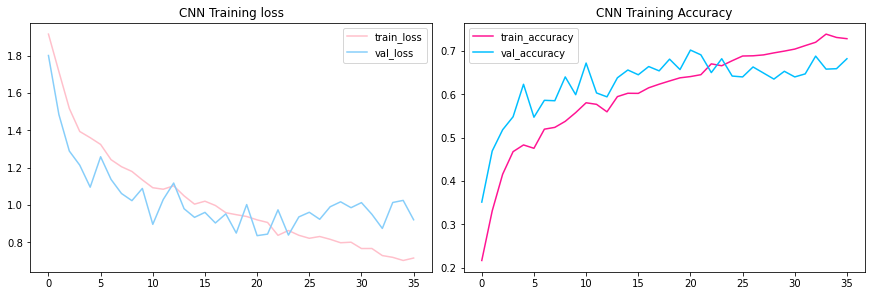

In [15]:
CNNHistory = pd.read_csv('CNNHistory.csv')
CNNHistory.columns = ['train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']
fig, ax = plt.subplots(1, 2, figsize=(12, 4), layout='constrained')
CNNHistory.plot.line(y=['train_loss','val_loss'], ax = ax[0], title = 'CNN Training loss', color = ['pink','lightskyblue'])
CNNHistory.plot(y=['train_accuracy','val_accuracy'], ax = ax[1], title = 'CNN Training Accuracy', color = ['deeppink', 'deepskyblue'])
#ax.figure.legend()

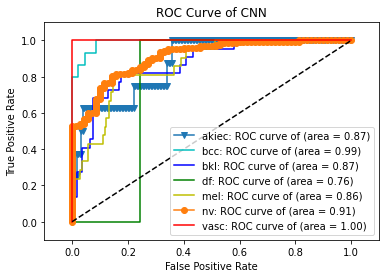

In [21]:
make_roc(model,'CNN', test_inc)

## ResNet

In [8]:
resnet = tf.keras.applications.resnet_v2.ResNet152V2(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classifier_activation='softmax'
)

conv = resnet.layers[-3].output
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv  = Activation('relu')(conv)
conv = Dropout(0.1)(conv)

output = GlobalAveragePooling2D()(conv)
output = Dense(7, activation='softmax')(output)
model = Model(inputs=resnet.input, outputs=output)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=0.1),
             loss='categorical_crossentropy',
             metrics=['accuracy'])
checkpoint=  ModelCheckpoint(filepath = 'ResNet150.hdf5',monitor='val_accuracy',save_best_only=True,save_weights_only=True)
Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=50, min_delta=0.001)
history = model.fit(train_batches,
                    steps_per_epoch=(len(train_batches)/10),
                    epochs=400,
                    verbose=2,
                    validation_data=valid_batches,callbacks=[checkpoint,Earlystop])

Epoch 1/400
161/161 - 120s - loss: 1.5259 - accuracy: 0.4344 - val_loss: 0.8623 - val_accuracy: 0.7116 - 120s/epoch - 745ms/step
Epoch 2/400
161/161 - 84s - loss: 0.8894 - accuracy: 0.6605 - val_loss: 0.8390 - val_accuracy: 0.7275 - 84s/epoch - 523ms/step
Epoch 3/400
161/161 - 87s - loss: 0.7485 - accuracy: 0.7294 - val_loss: 0.7324 - val_accuracy: 0.7475 - 87s/epoch - 537ms/step
Epoch 4/400
161/161 - 89s - loss: 0.6212 - accuracy: 0.7680 - val_loss: 0.6530 - val_accuracy: 0.7605 - 89s/epoch - 550ms/step
Epoch 5/400
161/161 - 91s - loss: 0.5358 - accuracy: 0.8050 - val_loss: 0.7345 - val_accuracy: 0.7226 - 91s/epoch - 564ms/step
Epoch 6/400
161/161 - 94s - loss: 0.4661 - accuracy: 0.8282 - val_loss: 0.9125 - val_accuracy: 0.6567 - 94s/epoch - 581ms/step
Epoch 7/400
161/161 - 91s - loss: 0.4222 - accuracy: 0.8444 - val_loss: 0.6250 - val_accuracy: 0.7754 - 91s/epoch - 567ms/step
Epoch 8/400
161/161 - 91s - loss: 0.3830 - accuracy: 0.8555 - val_loss: 0.7522 - val_accuracy: 0.7166 - 91s/e

Epoch 65/400
161/161 - 132s - loss: 0.0198 - accuracy: 0.9931 - val_loss: 0.6388 - val_accuracy: 0.8493 - 132s/epoch - 817ms/step
Epoch 66/400
161/161 - 131s - loss: 0.0253 - accuracy: 0.9907 - val_loss: 0.6700 - val_accuracy: 0.8543 - 131s/epoch - 809ms/step
Epoch 67/400
161/161 - 131s - loss: 0.0338 - accuracy: 0.9874 - val_loss: 0.5560 - val_accuracy: 0.8703 - 131s/epoch - 811ms/step
Epoch 68/400
161/161 - 131s - loss: 0.0285 - accuracy: 0.9905 - val_loss: 0.5989 - val_accuracy: 0.8553 - 131s/epoch - 813ms/step
Epoch 69/400
161/161 - 132s - loss: 0.0260 - accuracy: 0.9907 - val_loss: 0.8039 - val_accuracy: 0.8443 - 132s/epoch - 816ms/step
Epoch 70/400
161/161 - 133s - loss: 0.0245 - accuracy: 0.9915 - val_loss: 0.6433 - val_accuracy: 0.8643 - 133s/epoch - 826ms/step
Epoch 71/400
161/161 - 131s - loss: 0.0178 - accuracy: 0.9949 - val_loss: 0.6761 - val_accuracy: 0.8663 - 131s/epoch - 815ms/step
Epoch 72/400
161/161 - 133s - loss: 0.0147 - accuracy: 0.9951 - val_loss: 0.5966 - val_acc

In [9]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('ResNetHistory.csv', index=False)

In [32]:
resnet = tf.keras.applications.resnet_v2.ResNet152V2(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classifier_activation='softmax'
)

conv = resnet.layers[-3].output
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)

output = GlobalAveragePooling2D()(conv)
output = Dense(7, activation='softmax')(output)
model = Model(inputs=resnet.input, outputs=output)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=0.1),
             loss='categorical_crossentropy',
             metrics=['accuracy'])
model.load_weights( 'ResNet150.hdf5')


In [33]:
def modelEvaluation(probability, labels, class_indices):
    prediction = np.argmax(probability, axis= 1)
    labelName = list(class_indices.keys())
    confusion = pd.crosstab(prediction, labels, colnames=['Labels'], rownames= ['prediction'])
    confusion.columns = labelName
    confusion.columns.name = 'Labels'
    #confusion.index = labelName
    confusion.index.name = 'Prediction'
    #metrics = pd.DataFrame([precision_score(labels, prediction, average=None), recall_score(labels, prediction, average=None)],
    #                      columns=labelName, index = ['precesion','recall'])
    accuracy = accuracy_score(labels, prediction)
    print('Overall accuracy is:  {}'.format(accuracy))
    metrics = classification_report(labels, prediction, target_names=labelName)
    #confusion['Precision'] = precision_score(labels, prediction, average=None)
    #confusion.loc['Recall'] = np.insert(recall_score(labels, prediction, average=None),-1,accuracy)
    return confusion, metrics
    

In [34]:
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)
image_size = 224
batch_size = 24
test_inc =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)
test_predProbability = model.predict(test_inc)

Found 193 images belonging to 7 classes.
9/9 [==============================] - 3s 144ms/step


In [35]:
test_inc.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [36]:
incepDf, metrics= modelEvaluation(test_predProbability, test_inc.classes, test_inc.class_indices)
incepDf

Overall accuracy is:  0.8134715025906736


C:\Users\zwdua\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zwdua\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zwdua\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Labels,akiec,bcc,bkl,df,mel,nv,vasc
Prediction,,,,,,,
0,4,1,1,0,0,0,0
1,1,12,1,0,2,4,0
2,2,0,15,0,3,3,0
4,1,0,1,0,12,3,0
5,0,2,4,1,4,113,2
6,0,0,0,0,0,0,1


In [37]:
print(metrics)

              precision    recall  f1-score   support

       akiec       0.67      0.50      0.57         8
         bcc       0.60      0.80      0.69        15
         bkl       0.65      0.68      0.67        22
          df       0.00      0.00      0.00         1
         mel       0.71      0.57      0.63        21
          nv       0.90      0.92      0.91       123
        vasc       1.00      0.33      0.50         3

    accuracy                           0.81       193
   macro avg       0.65      0.54      0.57       193
weighted avg       0.81      0.81      0.81       193



<AxesSubplot:title={'center':'ResNet Training Accuracy'}>

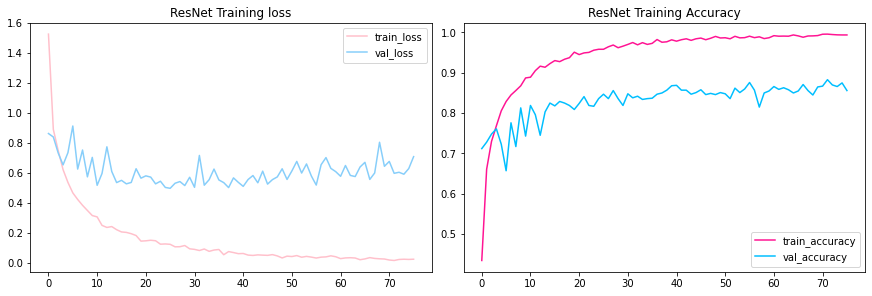

In [38]:
ResNetHistory = pd.read_csv('ResNetHistory.csv')
ResNetHistory.columns = ['train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']
fig, ax = plt.subplots(1, 2, figsize=(12, 4), layout='constrained')
ResNetHistory.plot.line(y=['train_loss','val_loss'], ax = ax[0], title = 'ResNet Training loss', color = ['pink','lightskyblue'])
ResNetHistory.plot(y=['train_accuracy','val_accuracy'], ax = ax[1], title = 'ResNet Training Accuracy', color = ['deeppink', 'deepskyblue'])
#ax.figure.legend()

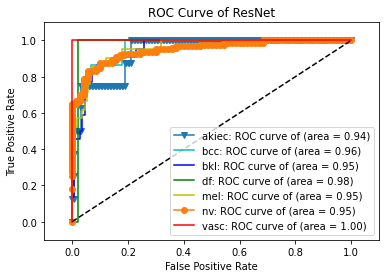

In [39]:
make_roc(model, 'ResNet', test_inc)

## VGG

In [22]:
vgggen=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
batch_size = 16
image_size = 224
print("\nTrain Batches: ")
train_vgg = vgggen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True,
                                      class_mode="sparse")

print("\nTest Batches: ")
valid_vgg =vgggen.flow_from_directory(valid_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False,
                                     class_mode="sparse")

# Note: shuffle=False causes the test dataset to not be shuffled
#test_batches = ImageDataGenerator(
#    preprocessing_function= \
#    keras.applications.mobilenet.preprocess_input).flow_from_directory(
#                                                    valid_path,
#                                                    target_size=(image_size,image_size),
#                                                    batch_size=val_batch_size,
#                                                    shuffle=False))


Train Batches: 
Found 38704 images belonging to 7 classes.

Test Batches: 
Found 1002 images belonging to 7 classes.


In [36]:
vgg = tf.keras.applications.vgg19.VGG19(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

conv = vgg.layers[-3].output

#conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))


#output = GlobalAveragePooling2D()(conv)
#output = Dense(7, activation='softmax')(output)
#conv=(Flatten()(conv))
conv=(Dense(4096,activation="relu")(conv))
conv=(Dense(4096,activation="relu")(conv))
conv=(Dense(7, activation="softmax")(conv))
model3 = Model(inputs=vgg.input, outputs = conv)


model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=0.1),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])
checkpoint=  ModelCheckpoint(filepath = 'VGG.hdf5',monitor='val_accuracy',save_best_only=True,save_weights_only=True)
Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=20, min_delta=0.001)
history = model3.fit(train_vgg,
                    steps_per_epoch=len(train_vgg)/10,
                    validation_data=valid_vgg,
                    epochs=400,
                    verbose=2,
                    callbacks=[checkpoint,Earlystop])

Epoch 1/400
241/241 - 62s - loss: 1.2807 - accuracy: 0.5028 - val_loss: 0.8840 - val_accuracy: 0.6537 - 62s/epoch - 258ms/step
Epoch 2/400
241/241 - 61s - loss: 0.9742 - accuracy: 0.6333 - val_loss: 0.8560 - val_accuracy: 0.6876 - 61s/epoch - 253ms/step
Epoch 3/400
241/241 - 62s - loss: 0.8559 - accuracy: 0.6774 - val_loss: 1.1324 - val_accuracy: 0.6228 - 62s/epoch - 255ms/step
Epoch 4/400
241/241 - 65s - loss: 0.7554 - accuracy: 0.7092 - val_loss: 0.7466 - val_accuracy: 0.7515 - 65s/epoch - 269ms/step
Epoch 5/400
241/241 - 63s - loss: 0.7149 - accuracy: 0.7299 - val_loss: 0.7960 - val_accuracy: 0.7126 - 63s/epoch - 262ms/step
Epoch 6/400
241/241 - 66s - loss: 0.6651 - accuracy: 0.7454 - val_loss: 0.6638 - val_accuracy: 0.7605 - 66s/epoch - 271ms/step
Epoch 7/400
241/241 - 65s - loss: 0.6204 - accuracy: 0.7621 - val_loss: 0.7964 - val_accuracy: 0.6976 - 65s/epoch - 267ms/step
Epoch 8/400
241/241 - 66s - loss: 0.5823 - accuracy: 0.7859 - val_loss: 0.6450 - val_accuracy: 0.7615 - 66s/epo

In [37]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('VGGHistory.csv', index=False)

In [23]:
vgg = tf.keras.applications.vgg19.VGG19(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

conv = vgg.layers[-3].output

#conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))


#output = GlobalAveragePooling2D()(conv)
#output = Dense(7, activation='softmax')(output)
#conv=(Flatten()(conv))
conv=(Dense(4096,activation="relu")(conv))
conv=(Dense(4096,activation="relu")(conv))
conv=(Dense(7, activation="softmax")(conv))
model3 = Model(inputs=vgg.input, outputs = conv)


model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=0.1),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])
model3.load_weights( 'VGG.hdf5')

In [24]:
vgggen=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
batch_size = 24
image_size = 224
test_inc =vgggen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)
test_predProbability = model3.predict(test_inc)

Found 193 images belonging to 7 classes.
9/9 [==============================] - 3s 142ms/step


In [28]:
incepDf, metrics= modelEvaluation(test_predProbability, test_inc.classes, test_inc.class_indices)
incepDf

Overall accuracy is:  0.7927461139896373


C:\Users\zwdua\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zwdua\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zwdua\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Labels,akiec,bcc,bkl,df,mel,nv,vasc
Prediction,,,,,,,
0,3,2,3,0,0,0,0
1,0,10,0,0,1,5,0
2,2,1,8,0,2,1,0
4,1,1,4,0,16,4,0
5,2,1,7,1,2,113,0
6,0,0,0,0,0,0,3


In [29]:
print(metrics)

              precision    recall  f1-score   support

       akiec       0.38      0.38      0.38         8
         bcc       0.62      0.67      0.65        15
         bkl       0.57      0.36      0.44        22
          df       0.00      0.00      0.00         1
         mel       0.62      0.76      0.68        21
          nv       0.90      0.92      0.91       123
        vasc       1.00      1.00      1.00         3

    accuracy                           0.79       193
   macro avg       0.58      0.58      0.58       193
weighted avg       0.78      0.79      0.78       193



<AxesSubplot:title={'center':'VGG Training Accuracy'}>

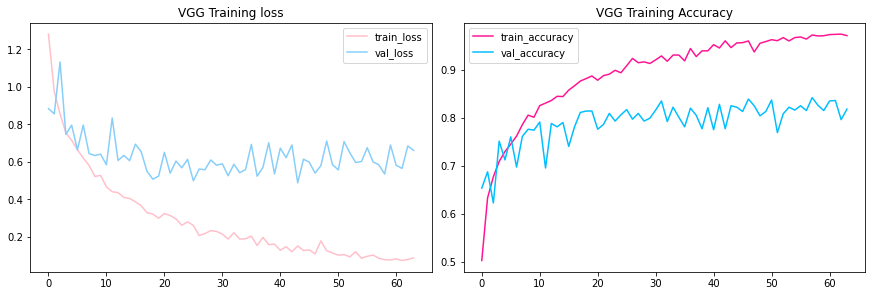

In [30]:
VGGHistory = pd.read_csv('VGGHistory.csv')
VGGHistory.columns = ['train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']
fig, ax = plt.subplots(1, 2, figsize=(12, 4), layout='constrained')
VGGHistory.plot.line(y=['train_loss','val_loss'], ax = ax[0], title = 'VGG Training loss', color = ['pink','lightskyblue'])
VGGHistory.plot(y=['train_accuracy','val_accuracy'], ax = ax[1], title = 'VGG Training Accuracy', color = ['deeppink', 'deepskyblue'])
#ax.figure.legend()

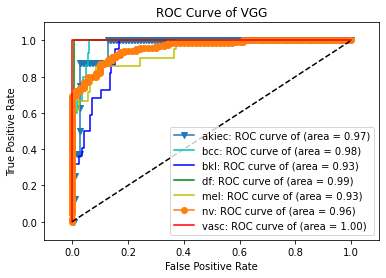

In [31]:
make_roc(model3, 'VGG', test_inc)

## InceptionV3

In [42]:
gen2=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)
batch_size = 16
image_size = 224
print("\nTrain Batches: ")
train_inc = gen2.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
valid_inc =gen2.flow_from_directory(valid_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)

model4 = tf.keras.applications.inception_v3.InceptionV3(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)



conv = model4.layers[-3].output
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)

output = GlobalAveragePooling2D()(conv)
output = Dense(7, activation='softmax')(output)
model4 = Model(inputs=model4.input, outputs=output)

model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=0.1),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

checkpoint=  ModelCheckpoint(filepath = 'Inception.hdf5',monitor='val_accuracy',save_best_only=True,save_weights_only=True)
Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=50, min_delta=0.001)
history4 = model4.fit(train_inc,
                    steps_per_epoch=int(len(train_inc)/10),
                    epochs=400,
                    verbose=2,
                    validation_data=valid_inc,callbacks=[checkpoint,Earlystop])


Train Batches: 
Found 38704 images belonging to 7 classes.

Test Batches: 
Found 1002 images belonging to 7 classes.
Epoch 1/400
241/241 - 53s - loss: 1.5470 - accuracy: 0.4136 - val_loss: 0.9197 - val_accuracy: 0.7026 - 53s/epoch - 219ms/step
Epoch 2/400
241/241 - 36s - loss: 1.0100 - accuracy: 0.6247 - val_loss: 0.8603 - val_accuracy: 0.7116 - 36s/epoch - 149ms/step
Epoch 3/400
241/241 - 36s - loss: 0.8106 - accuracy: 0.6989 - val_loss: 0.8374 - val_accuracy: 0.7485 - 36s/epoch - 151ms/step
Epoch 4/400
241/241 - 36s - loss: 0.7207 - accuracy: 0.7388 - val_loss: 0.7387 - val_accuracy: 0.7515 - 36s/epoch - 151ms/step
Epoch 5/400
241/241 - 37s - loss: 0.6530 - accuracy: 0.7565 - val_loss: 0.6322 - val_accuracy: 0.7824 - 37s/epoch - 152ms/step
Epoch 6/400
241/241 - 36s - loss: 0.6040 - accuracy: 0.7772 - val_loss: 0.6564 - val_accuracy: 0.7784 - 36s/epoch - 151ms/step
Epoch 7/400
241/241 - 37s - loss: 0.5707 - accuracy: 0.7899 - val_loss: 0.7175 - val_accuracy: 0.7226 - 37s/epoch - 154m

Epoch 65/400
241/241 - 38s - loss: 0.0641 - accuracy: 0.9769 - val_loss: 0.5155 - val_accuracy: 0.8663 - 38s/epoch - 157ms/step
Epoch 66/400
241/241 - 38s - loss: 0.0498 - accuracy: 0.9826 - val_loss: 0.5083 - val_accuracy: 0.8633 - 38s/epoch - 156ms/step
Epoch 67/400
241/241 - 39s - loss: 0.0554 - accuracy: 0.9805 - val_loss: 0.4552 - val_accuracy: 0.8723 - 39s/epoch - 161ms/step
Epoch 68/400
241/241 - 39s - loss: 0.0541 - accuracy: 0.9821 - val_loss: 0.4855 - val_accuracy: 0.8772 - 39s/epoch - 163ms/step
Epoch 69/400
241/241 - 40s - loss: 0.0506 - accuracy: 0.9847 - val_loss: 0.5118 - val_accuracy: 0.8563 - 40s/epoch - 165ms/step
Epoch 70/400
241/241 - 39s - loss: 0.0450 - accuracy: 0.9837 - val_loss: 0.5010 - val_accuracy: 0.8603 - 39s/epoch - 163ms/step
Epoch 71/400
241/241 - 38s - loss: 0.0459 - accuracy: 0.9847 - val_loss: 0.5292 - val_accuracy: 0.8613 - 38s/epoch - 156ms/step
Epoch 72/400
241/241 - 38s - loss: 0.0550 - accuracy: 0.9805 - val_loss: 0.6472 - val_accuracy: 0.8423 -

In [43]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('InceptionHistory.csv', index=False)

In [49]:
test_inc =gen2.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)
test_predProbability = model4.predict(test_inc)

Found 193 images belonging to 7 classes.
9/9 [==============================] - 2s 129ms/step


In [48]:
model4 = tf.keras.applications.inception_v3.InceptionV3(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)



conv = model4.layers[-3].output
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)

output = GlobalAveragePooling2D()(conv)
output = Dense(7, activation='softmax')(output)
model4 = Model(inputs=model4.input, outputs=output)

model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=0.1),
             loss='categorical_crossentropy',
             metrics=['accuracy'])
model4.load_weights('Inception.hdf5')

In [42]:
gen2=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)
test_inc =gen2.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)
test_predProbability = model4.predict(test_inc)

Found 193 images belonging to 7 classes.
9/9 [==============================] - 3s 152ms/step


In [43]:
incepDf, metrics= modelEvaluation(test_predProbability, test_inc.classes, test_inc.class_indices)
incepDf

Overall accuracy is:  0.8601036269430051


Labels,akiec,bcc,bkl,df,mel,nv,vasc
Prediction,,,,,,,
0,5,1,1,0,0,0,0
1,0,12,0,0,0,0,0
2,2,0,16,0,1,3,0
3,0,0,0,1,0,0,0
4,0,0,2,0,13,4,0
5,1,2,3,0,7,116,0
6,0,0,0,0,0,0,3


In [44]:
print(metrics)

              precision    recall  f1-score   support

       akiec       0.71      0.62      0.67         8
         bcc       1.00      0.80      0.89        15
         bkl       0.73      0.73      0.73        22
          df       1.00      1.00      1.00         1
         mel       0.68      0.62      0.65        21
          nv       0.90      0.94      0.92       123
        vasc       1.00      1.00      1.00         3

    accuracy                           0.86       193
   macro avg       0.86      0.82      0.84       193
weighted avg       0.86      0.86      0.86       193



In [45]:
InceptionHistory = pd.read_csv('InceptionHistory.csv')
InceptionHistory.columns = ['train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']

<AxesSubplot:title={'center':'Inception Training Accuracy'}>

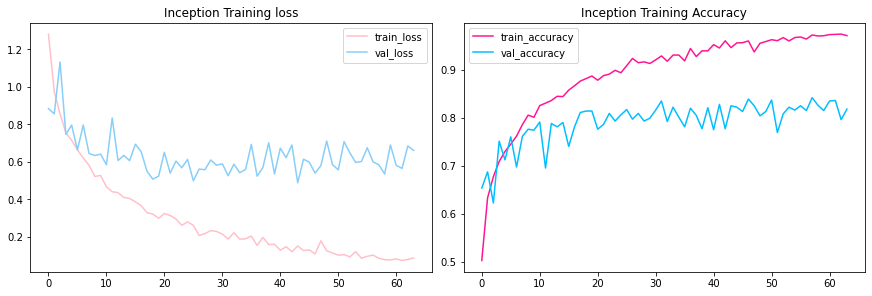

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), layout='constrained')
InceptionHistory.plot.line(y=['train_loss','val_loss'], ax = ax[0], title = 'Inception Training loss', color = ['pink','lightskyblue'])
InceptionHistory.plot(y=['train_accuracy','val_accuracy'], ax = ax[1], title = 'Inception Training Accuracy', color = ['deeppink', 'deepskyblue'])
#ax.figure.legend()


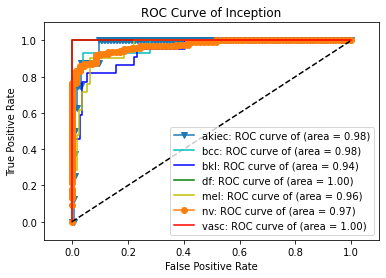

In [47]:
make_roc(model4, 'Inception', test_inc)